## Udemy Video Subtitle Vectorization (Expert on LLM engineering) 

This project will uses subtitle files from Ed Donners excellent LLM engineering course on Udemy.

These can be downloaded using the following process:
- Useing an android phone, download Udemy app and open the LLM engineering course. 
- There is option to download the videos as single files or section wise. 
- Download them and along with those videos subs or cc are also downloaded as .srt’s.
- Plug in your laptop to the android phone using USB and select file transfer in the notification.
- Open a file explorer and copy the subtitle files (srt format)
- Here’s the location of subs in android "internal storage/android/data/com.udemy.android/files/udemy-subtitle-downloads"

the raw srt files are stored in the folder "subtitles/srts". The code below will use the langchain textloader but will preprocess the srt files to remove the timestamps.

### Note: this is only for educational and testing purposes and you should contact Ed Donnner to seek his permission if you want to use the subtitles.

In [62]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [61]:
# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import re

In [41]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [42]:
# Load environment variables in a file called .env

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [43]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("subtitles/srts/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

def preprocess_srt_content(content):
    """
    Preprocess the content of an SRT file to remove timing information and the WEBVTT header.
    """
    # Remove the WEBVTT header
    content = re.sub(r'^WEBVTT\s*', '', content, flags=re.IGNORECASE)
    # Remove timing lines (e.g., 00:00.680 --> 00:08.540)
    content = re.sub(r'\d{2}:\d{2}\.\d{3} --> \d{2}:\d{2}\.\d{3}', '', content)
    # Remove extra newlines and strip leading/trailing whitespace
    return "\n".join(line.strip() for line in content.splitlines() if line.strip())

documents = []
for folder in folders:
    video_number = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/en_US.srt", loader_cls=TextLoader)
    folder_docs = loader.load()

    for doc in folder_docs:
        # Preprocess the document content
        cleaned_content = preprocess_srt_content(doc.page_content)
        # Replace the original content with the cleaned content
        doc.page_content = cleaned_content
        # Add metadata
        doc.metadata["video_number"] = video_number
        documents.append(doc)


# Please note:

In the next cell, we split the text into chunks.

If you have problems, you can try to fix them by changing the chunk_size from 1,000 to 2,000 and the chunk_overlap from 200 to 400.  
This shouldn't be required; but if it happens to you, please make that change!  
(Note that LangChain may give a warning about a chunk being larger than 1,000 - this can be safely ignored).

In [44]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

In [45]:
len(chunks)

217

In [46]:
video_numbers = set(chunk.metadata['video_number'] for chunk in chunks)
print(f"Video numbers found: {', '.join(video_numbers)}")

Video numbers found: 60616407, 59170043, 59507329, 59505329, 60614541, 59471979, 59166453, 59295587, 59295545, 59670259, 59166421, 59295493, 59166461, 59166919, 60616845, 59472873, 59668027, 59472017, 59668181, 60614589, 59473021, 59166443, 59507017, 60619721, 59170055, 59665129, 59295439, 59673721, 59472441, 59507423, 59473201, 59472011, 59671567, 60616927, 59170297, 59667365, 60620395, 59295599, 59669375, 59507435, 59297749, 59297599, 59297603, 59472491, 59297595, 60616663, 59170165, 59472383, 59506713, 59297561, 60620397, 59166951, 59472503, 59295609, 59670933, 59170291, 59295429, 59473071, 59472027, 59166949, 60616629, 60619227, 59297733, 59669211, 59473191, 59667829, 59295423, 59170037, 59170025, 59170227, 59671231, 59673449, 59503703, 59669631, 59166353, 59671441, 59673663, 59668923, 60619619, 59170255, 59508289, 59507785, 60619299, 60619501, 60616623, 59473147, 59170135, 59473089, 59295435, 59472425, 59295579, 59669389, 60617259, 59673639, 59508297, 60619247, 60619289, 59472137,

## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [47]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk

embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [48]:
# Check if a Chroma Datastore already exists - if so, delete the collection to start from scratch

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [49]:
# Create our Chroma vectorstore!

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 217 documents


In [50]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 1,536 dimensions


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [51]:
# Convert the video numbers into unique colors that we can visualize
import hashlib

def video_numbers_to_hex_colors(video_numbers):
    return [f"#{hashlib.sha256(v.encode()).hexdigest()[:6]}" for v in video_numbers]



In [58]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
video_numbers = [metadata['video_number'] for metadata in result['metadatas']]
colors = video_numbers_to_hex_colors(strings)



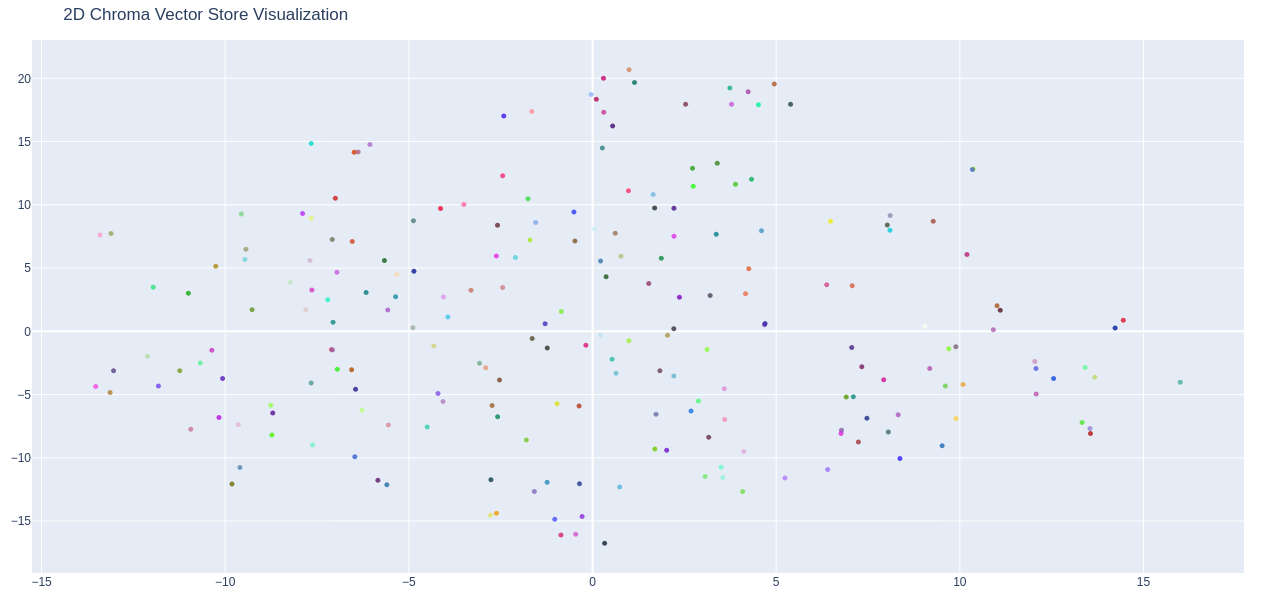

In [55]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Video: {t}<br>Text: {d[:100]}..." for t, d in zip(video_numbers , documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

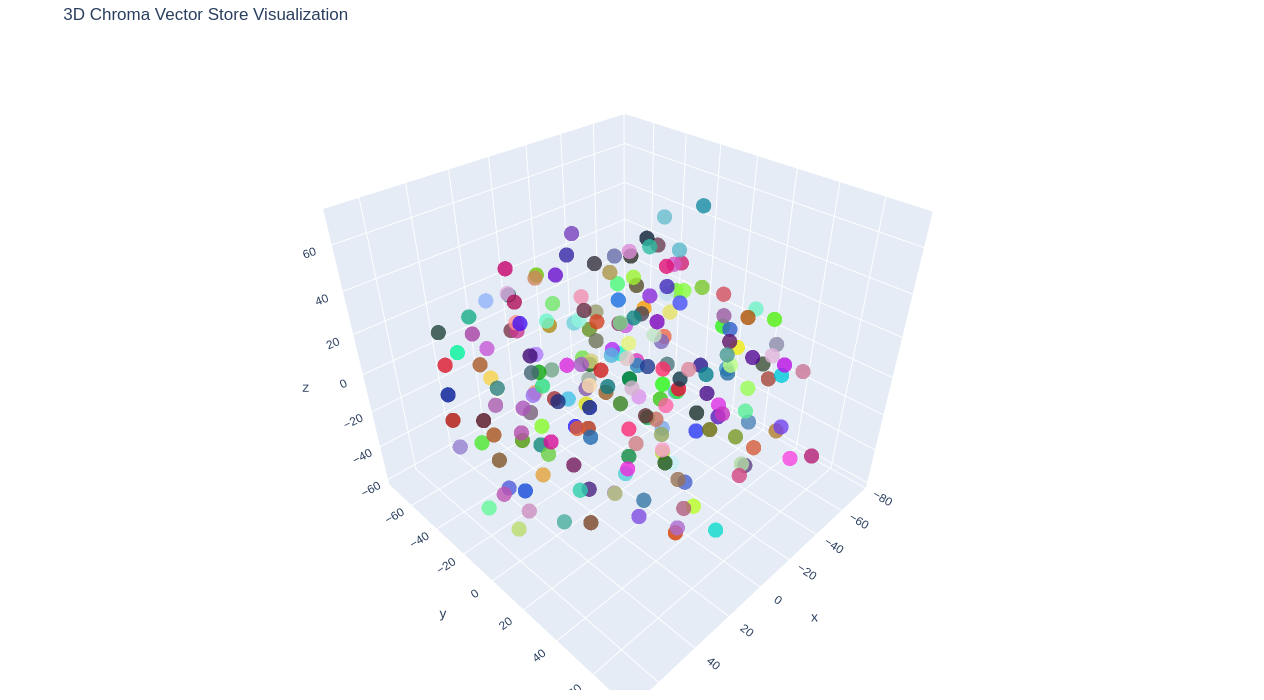

In [56]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Video: {t}<br>Text: {d[:100]}..." for t, d in zip(video_numbers, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()